In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
def file_path(filename, folder):
    """
    Returns the path of a file given its name and the folder it resides

    Parameters
    ----------
    file_name : str
        Name of file
    folder : str
        Name of folder where the file with name 'file_name' resides. Must be
        inside current directory

    Returns
    ----------
        path : str
    """
    path = os.path.join(os.getcwd(), folder, filename)
    return path
    
train_path = file_path('train.csv', 'data')
test_path = file_path('test.csv', 'data')

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

## Exploratory Data Analysis

To create the features that are going to be used as inputs to the tweet classification model it is important to analyze the information contained in the text of each tweet. Let's do some exploratory data analysis to extract useful information that can be transformed into features. Let's begin by exploring the keyword columnt.

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
# Let's look at keyword column bby creating a dictionary
keywords = dict(train.keyword.value_counts())
# sort the dictionary by value
keywords = dict(sorted(keywords.items(), key=lambda item: item[1], reverse=True))

In [8]:
len(keywords)

221

The keyword column contains relevant information, as seen in the following figure. Words like armageddon or blaze are more frequent in fake disaster tweets. Note, however, that the keyword column is a categorical column of large cardinality, and therefore one-hot vectors is not an appropriate encoding technique. To encode this column, we can use target encoding.For this purpose, let's create a new function.

<Axes: xlabel='count', ylabel='keyword'>

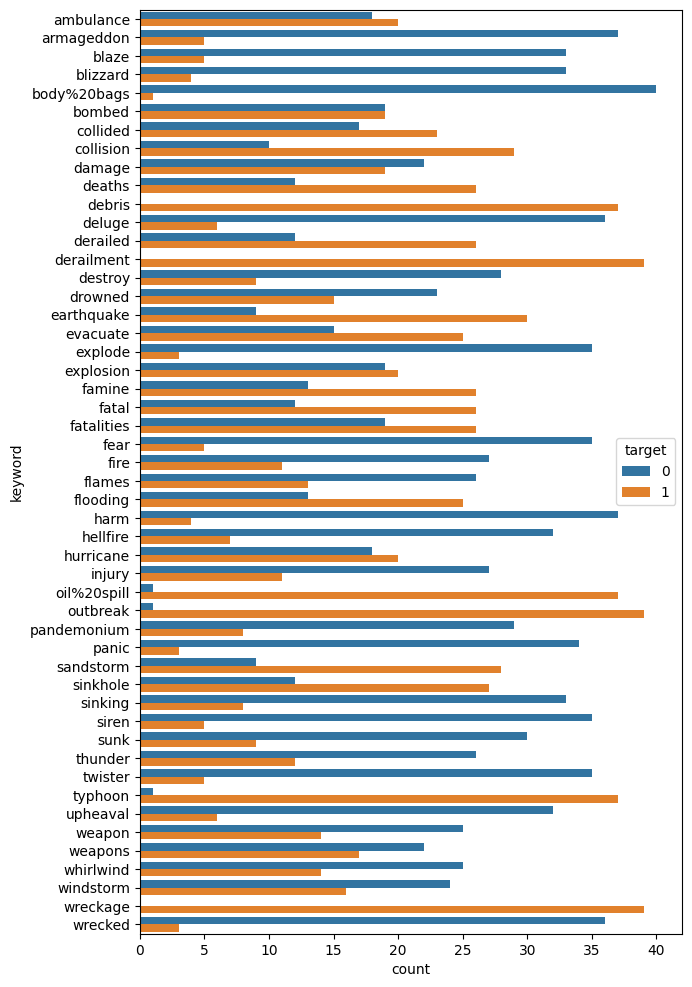

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7,12)) 

sns.countplot(data = train[train['keyword'].isin(list(keywords.keys())[:50])], y='keyword', hue='target', ax=ax)

In [4]:
train['keyword'] = train['keyword'].fillna('Unknown')
test['keyword'] = test['keyword'].fillna('Unknown')

In [11]:
train['keyword'].value_counts()

keyword
Unknown                  61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

In [5]:
# define a function to apply target encoding using cross-validatio

from sklearn.model_selection import KFold

def target_encode_train(dataframe, column, target, n_splits=5, crossing=10, rate=20):
    """
    Performs target encoding on 'column' using Kfold cross-vaidation

    Parameters
    ----------
    dataframe : Pandas DataFrame
        Dataframe that contains columns
    
    column : string
        Column to apply target encoding

    target : string
        Target columns use to encode 'column'

    suffix (optional) : string, default = 'target'
        String used to rename the new target-encoded column

    Returns
    ----------
    dataframe : Pandas Dataframe
        Dataframe containing the transformed columns
    """
    temp = dataframe[[column, target]].copy()
    kf = KFold(n_splits = n_splits, shuffle=True)

    prior = np.mean(temp['target'])
    
    lamb = lambda x : (1/(1+np.exp(-(x-crossing)/rate))) if x > 0 else 0 
    
    folds = []
    indices = []
    for result in kf.split(temp):
        train_df = temp.iloc[result[0]].groupby(column)[target].agg(['count','mean']).reset_index(drop=False)
        test_df = temp.iloc[result[1]].merge(train_df, on=column, how='left')[[column, 'count','mean']]
        test_df.fillna({'count':0, 'mean':0}, inplace=True)
        test_df['weight'] =  test_df['count'].apply(lamb)
        test_df['Z'] = test_df['weight'] * test_df['mean'] + (1 - test_df['weight']) * prior
        indices.append(result[1])
        folds.append(test_df)

    indices = np.concatenate(indices)
    df = pd.concat(folds, ignore_index=True)
    df.set_index(indices, inplace=True)
    df.sort_index(inplace=True)
    
    return df[['Z']]

def target_encode_test(dataframe_train, dataframe_test, column, target, crossing=10, rate=20):
    """
    Performs target encoding on 'column' using Kfold cross-vaidation

    Parameters
    ----------
    dataframe : Pandas DataFrame
        Dataframe that contains columns
    
    column : string
        Column to apply target encoding

    target : string
        Target columns use to encode 'column'

    suffix (optional) : string, default = 'target'
        String used to rename the new target-encoded column

    Returns
    ----------
    dataframe : Pandas Dataframe
        Dataframe containing the transformed columns
    """

    temp_train = dataframe_train[[column, target]].copy()
    temp_test = dataframe_test[[column]].copy()

    prior = np.mean(temp_train['target'])
    
    lamb = lambda x : (1/(1+np.exp(-(x-crossing)/rate))) if x > 0 else 0 
    
    train_df = temp_train.groupby(column)[target].agg(['count', 'mean']).reset_index(drop=False)
    test_df = temp_test.merge(train_df, on=column, how='left')[['count', 'mean']]
    test_df.fillna({'count':0, 'mean':0}, inplace=True)
    test_df['weight'] =  test_df['count'].apply(lamb)
    test_df['Z'] = test_df['weight'] * test_df['mean'] + (1 - test_df['weight']) * prior

    return  test_df[['Z']]

In [6]:
# encode keyword column using target encoding
train['keyword_target_enc'] =  target_encode_train(train, 'keyword', 'target')
test['keyword_target_enc'] =  target_encode_test(train, test, 'keyword', 'target')

Now we turn our attention to the 'text' column. Before analyzing these data, we must perform a series of preprocessing steps to remove stopwords and punctuation, lowercase capitalized words and apply lemmatization. Note that in text classification, we want the differences between classes to stand out; words like of, the, or and are present in all types of documents and therefore do not help differentiate between documents.   

First, let's explore some tweets to understand what data we are working with. Note that there are a lot of variations across the texts. Some of them contain mentions, hashtags, and URLs.

I will define functions to create some basic features, such as the number of words of each token, the number of mentions, hashtags, and URLs in each tweet. 

In [9]:
print(*train['text'].iloc[50:100], sep='\n')

Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k
Man wife get six years jail for setting ablaze niece
http://t.co/eV1ahOUCZA
SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintendent Lanford Salmon has r ... - http://t.co/vplR5Hka2u http://t.co/SxHW2TNNLf
Police: Arsonist Deliberately Set Black Church In North CarolinaåÊAblaze http://t.co/pcXarbH9An
Noches El-Bestia '@Alexis_Sanchez: happy to see my teammates and training hard ?? goodnight gunners.?????? http://t.co/uc4j4jHvGR'
#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen Front in #Diyala http://t.co/4IzFdYC3cg
TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF
Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @Û_ https://t.co/cYoMPZ1A0Z
They sky was ablaze tonight in Los Angeles. I'm expecting IG and FB to be filled with sunset shots if I know my peeps!!
How the W

In [7]:
import re
pm = re.compile(r'@\w+')

def mention_count(tweet):
    """
    Returns the number of mentions in each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        count : int
    """
    count = len(pm.findall(tweet))
    return count


ph = re.compile(r'#\w+')

def hashtag_count(tweet):
    """
    Returns the number of hashtags in each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        count : int
    """
    count = len(ph.findall(tweet))
    return count


purls = re.compile(r'http[s]?:\/\/\S+')

def url_count(tweet):
    """
    Returns the number of urls in each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        count : int
    """
    count = len(purls.findall(tweet))
    return count


def token_count(tweet):
    """
    Returns the number of unprocessed tokens in each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        len : int
    """
    tokens = tweet.split()
    return len(tokens)


def char_count(tweet):
    """
    Returns the number of characters in each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        len : int
    """
    return len(tweet)


def avg_word_length(tweet):
    """
    Returns the average length of words of each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        avg_len : float
    """
    tokens = tweet.split()
    lens = [len(word) for word in tokens]
    avg_len = sum(lens)/len(lens)
    return avg_len

def median_word_length(tweet):
    """
    Returns the median of length of words in each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        med_len : float
    """
    tokens = tweet.split()
    lens = [len(word) for word in tokens]
    med_len = np.median(lens)
    return med_len

In [8]:
# just testing the functions
tweet = "@Navista7 Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680"
count = mention_count(tweet)
print(f"Number of mentions: {count}")

tweet = "#BREAKING: there was a deadly motorcycle car accident that happened to #Hagerstown today. I'll have more details at 5 @Your4State. #WHAG"
count = hashtag_count(tweet)
print(f"Number of hashtags: {count}")

tweet = "Aashiqui Actress Anu Aggarwal On Her Near-Fatal Accident http://t.co/6Otfp31LqW Suffield Alberta Accident https://t.co/bPTmlF4P10 https://www.kaggle.com/competitions/nlp-getting-started/data"
count = url_count(tweet)
print(f"Number of urls: {count}")

Number of mentions: 2
Number of hashtags: 3
Number of urls: 3


In [9]:
train['number_of_mentions'] = train['text'].apply(mention_count)
train['number_of_hashtags'] = train['text'].apply(hashtag_count)
train['number_of_urls'] = train['text'].apply(url_count)

train['token_count'] = train['text'].apply(token_count)
train['char_count'] = train['text'].apply(char_count)
train['avg_word_length'] = train['text'].apply(avg_word_length)
train['median_word_length'] = train['text'].apply(median_word_length)

In [10]:
test['number_of_mentions'] = test['text'].apply(mention_count)
test['number_of_hashtags'] = test['text'].apply(hashtag_count)
test['number_of_urls'] = test['text'].apply(url_count)

test['token_count'] = test['text'].apply(token_count)
test['char_count'] = test['text'].apply(char_count)
test['avg_word_length'] = test['text'].apply(avg_word_length)
test['median_word_length'] = test['text'].apply(median_word_length)

In [10]:
print(pd.crosstab(train['number_of_mentions'], train['target']))
print(pd.crosstab(train['number_of_hashtags'], train['target']))
print(pd.crosstab(train['number_of_urls'], train['target']))

target                 0     1
number_of_mentions            
0                   2999  2605
1                   1019   512
2                    237   101
3                     47    39
4                     19    11
5                     14     3
6                      5     0
7                      1     0
8                      1     0
target                 0     1
number_of_hashtags            
0                   3457  2413
1                    486   478
2                    199   208
3                    108    94
4                     44    27
5                     17    22
6                     20     7
7                      3     4
8                      1     7
9                      2     0
10                     3     7
11                     2     0
13                     0     4
target             0     1
number_of_urls            
0               2543  1099
1               1414  1835
2                369   328
3                 13     9
4                  3     0


<Axes: xlabel='number_of_mentions', ylabel='Density'>

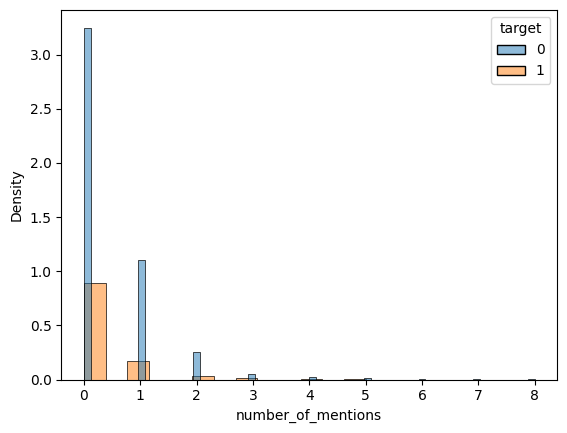

In [12]:
# apparently fake tweets have a larger number of mentions
sns.histplot(data=train, x='number_of_mentions', hue='target', stat='density', common_bins=False)

<Axes: xlabel='char_count', ylabel='Percent'>

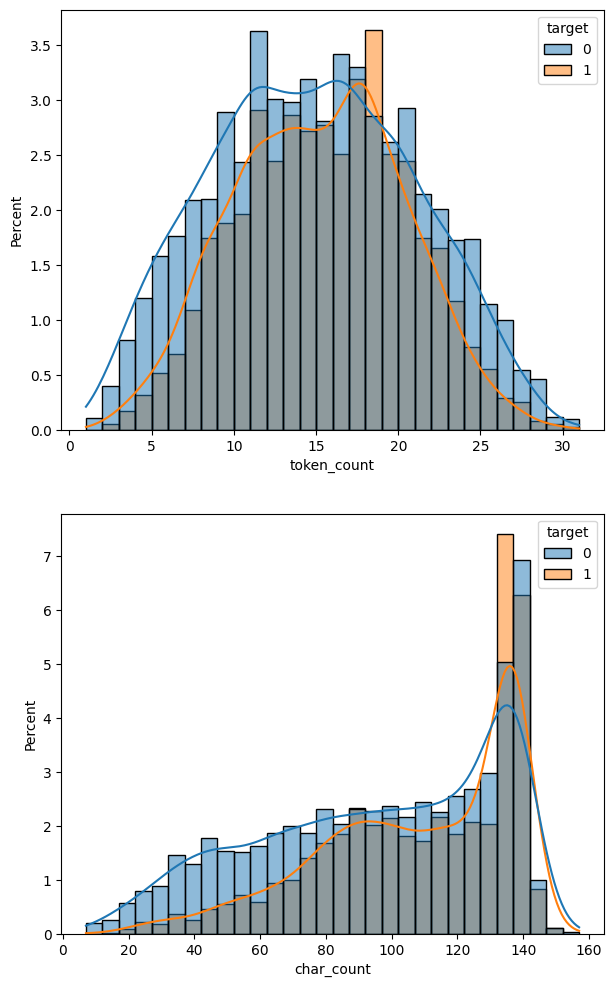

In [16]:
# apparently fake tweets have a larger number of mentions
fig, ax = plt.subplots(2,1, figsize=(7,12))
sns.histplot(data=train, x='token_count', hue='target', bins=30, kde=True, ax=ax[0], stat='percent')
sns.histplot(data=train, x='char_count', hue='target', bins=30, kde=True, ax=ax[1], stat='percent')

<Axes: xlabel='median_word_length', ylabel='Percent'>

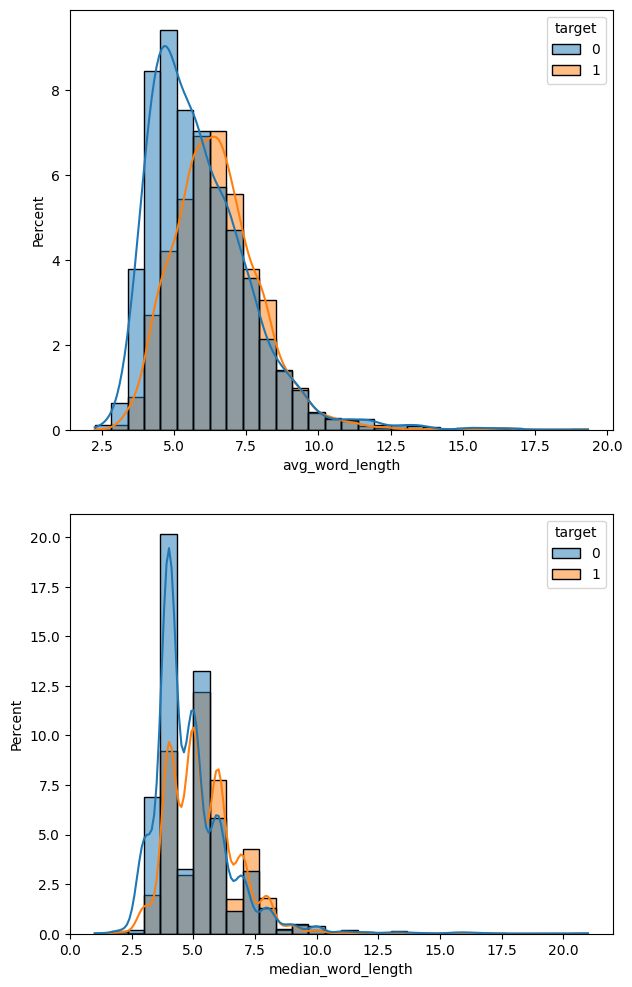

In [21]:
fig, ax = plt.subplots(2,1, figsize=(7,12))

sns.histplot(data=train, x='avg_word_length', hue='target', bins=30, kde=True, stat='percent', ax=ax[0])
sns.histplot(data=train, x='median_word_length', hue='target', bins=30, kde=True, stat='percent', ax=ax[1])

Now we can proceed to tokenize the texts and apply the preprocessing steps. This process will take the text of each tweet and transform it into a list of tokens that will serve as features. For now, I will focus on simple features consisting of 1-grams and simple statistics. Once we have built a simple, functional model, we will add more complex features and use sophisticated algorithms.

In [ ]:
"""
    Returns the number of unprocessed tokens in each tweet

    Parameters
    ----------
    tweet : str
        Text of tweet
        
    Returns
    ----------
        len : int
    """

### Tokenization

In [11]:
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize, TweetTokenizer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
import itertools
import re

# lowercase the words in tweet
def lowercase(tweet):
    """
    Convert capitalized words to lowercase.

    Parameters
    ----------
    tweet : str
        Text of tweet

    Returns
    ----------
    tweet : str
        Lowercased version of tweet
        
    """
    tweet = tweet.lower()
    return tweet
    

def tokenize(tweet, tokenizer = 'word_tokenize'):
    """
    Returns a list of tokens from 'tweet' using 'tokenizer'.

    Parameters
    ----------
    tweet : str
        Text of tweet

    tokenizer : str, default = 'word_tokenizer'
        Controls which tokenizer is used. Options are: 'word_tokenize', 'TweetTokenizer'

    Returns
    ----------
    tokens : list
        list of tokens
        
    """
    if tokenizer == 'word_tokenize':
        tokens = word_tokenize(tweet)
        
    elif tokenizer == 'TweetTokenizer':
        tknzr =  TweetTokenizer(reduce_len=True)
        tokens =  tknzr.tokenize(tweet)

    return tokens
#nltk.download(


def remove_punctuation(tokens):
    """
    Returns a list of tokens with punctuation removed.

    Parameters
    ----------
    tokens : list
        List of tokens

    stopwords : list
        List of stopwords to remove

    Returns
    ----------
    tokens : list
        
    """
    tokens = [word for word in tokens if word not in string.punctuation]
    return tokens
    

def remove_stopwords(tokens, stopwords):
    """
    Returns a list of tokens with stopwords removed.

    Parameters
    ----------
    tokens : list
        List of tokens

    stopwords : list
        List of stopwords to remove

    Returns
    ----------
    tokens : list
        
    """
    tokens = [token for token in tokens if token not in stopwords]
    return tokens


def remove_regex(tokens, regex):
    """
    Removes token that match regex pattern.

    Parameters
    ----------
    tokens : list
        List of tokens

    regex : string
        Regular expresion pattern

    Returns
    ----------
    tokens : list
        
    """

    tokens = [token for token in tokens if not re.match(regex, token)]
    return tokens

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import linalg

In [13]:
train['tokens'] = train['text'].apply(lowercase)
train['tokens'] = train['tokens'].apply(tokenize, tokenizer='TweetTokenizer')
train['tokens'] = train['tokens'].apply(remove_punctuation)
train['tokens'] = train['tokens'].apply(remove_regex, regex=r'\d+')
#train['tokens'] = train['tokens'].apply(remove_regex, regex=r'\[xu]\w+')

stpws = stopwords.words('english')
train['tokens'] = train['tokens'].apply(remove_stopwords, stopwords=stpws)

In [14]:
test['tokens'] = test['text'].apply(lowercase)
test['tokens'] = test['tokens'].apply(tokenize, tokenizer='TweetTokenizer')
test['tokens'] = test['tokens'].apply(remove_punctuation)
test['tokens'] = test['tokens'].apply(remove_regex, regex=r'\d+')
#train['tokens'] = train['tokens'].apply(remove_regex, regex=r'\[xu]\w+')

#stpws = stopwords.words('english')
test['tokens'] = test['tokens'].apply(remove_stopwords, stopwords=stpws)

In [22]:
train['tokens'].head()

0    [deeds, reason, #earthquake, may, allah, forgi...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, #wildfires, evacuation, orde...
4    [got, sent, photo, ruby, #alaska, smoke, #wild...
Name: tokens, dtype: object

Before converting tokens to vectors, using the TF-IDF vectorizer, we need to rejoin tokens into a single string. 

In [15]:
train['new_text'] = train['tokens'].apply(lambda token_list: ' '.join(token_list))

In [16]:
test['new_text'] = test['tokens'].apply(lambda token_list: ' '.join(token_list))

In [17]:
# Save train file to use in application
train.to_csv('processed_train.csv', index=False)

### Tf-Idf

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
train_vectors = tfidf_vectorizer.fit_transform(train["new_text"].iloc[0:])
test_vectors = tfidf_vectorizer.transform(test['new_text'].iloc[0:])

In [43]:
# Apply SVD to reduce dimensionality
U, s, Vh = linalg.svds(train_vectors.transpose(), k=150)

Using SVD, we reduced the dimensionality of word and document vectors, as seen from the resulting matrices' size. This reduction allows bringing vectors closer in distance and making similarities stand out.

In [44]:
U.shape, s.shape, Vh.shape

((10000, 150), (150,), (150, 7613))

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
def similarity(word1, word2, vectorizer, U=U, s=s, Vh=Vh):
    """
    Computes cosine similarity from Singular Value Decomposition
    matrices.

    Parameters
    ----------
    word1 : string
        First word
    
    word2 : string
        Second word

    vectorizer: Transformer
        Vectorizer that contains the vocabulary as a dictionary

    Returns
    ----------
        similarity : int
    """
    ind1 = vectorizer.vocabulary_[word1]
    ind2 = vectorizer.vocabulary_[word2]

    k = U.shape[1]

    vec1 = (np.diag(s) @ U[ind1]).reshape((1,k))
    vec2 = (np.diag(s) @ U[ind2]).reshape((1,k))

    return cosine_similarity(vec1, vec2)[0,0]

In [46]:
similarity_dict = dict()
for word in list(tfidf_vectorizer.vocabulary_.keys())[0:]:
    similarity_dict[word] = similarity('emergency', word, tfidf_vectorizer)

similarity_dict = dict(sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True))

In [47]:
list(similarity_dict.items())[0:100]

[('emergency', 1.0),
 ('tookitlikeaman', 0.9808246667055006),
 ('shutdown', 0.9780562919141506),
 ('surgery', 0.9720473507671216),
 ('radychildrens', 0.9711985809310402),
 ('plumbing', 0.9576015146726511),
 ('medicine', 0.9558678400712878),
 ('rebeccaforreal', 0.9533177414902475),
 ('wisconsin', 0.9533177414902475),
 ('nbc15', 0.9533177414902475),
 ('pis0aivrbr', 0.9533177414902475),
 ('printable', 0.9466630784871031),
 ('naex0q1ax0', 0.9466630784871031),
 ('odai', 0.944814168761306),
 ('pjigxpvpl0', 0.944814168761306),
 ('wipp', 0.9440290212492984),
 ('procedures', 0.9425149282072287),
 ('practitioner', 0.9333548352177873),
 ('recruitment', 0.9333548352177873),
 ('specialists', 0.9301652564631994),
 ('presents', 0.929837877789722),
 ('yennora', 0.9284002494944995),
 ('unsure', 0.9239560159082909),
 ('paging', 0.9239560159082909),
 ('uxqkieqdyf', 0.9239560159082909),
 ('nueva', 0.9210789432531947),
 ('newyorkcity', 0.9210186919951724),
 ('chemical', 0.916749362237427),
 ('supervisor', 

In [68]:
# we can use the matrix Vh to create the new features
features = (np.diag(s) @ Vh).T
columns = [f"feature{i}" for i in range(1,101)]
new_features = pd.DataFrame(data=features, columns=columns)
new_features.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100
0,-0.007857,0.019074,-0.019468,0.010963,0.006087,-0.006449,-0.016292,0.015233,0.003668,-0.006458,...,0.094905,0.021958,-0.009447,0.012319,0.001725,0.000261,-0.016147,0.006599,-0.009180,-0.019513
1,-0.000772,-0.019701,0.002829,-0.019804,0.033770,-0.011489,0.003246,-0.006070,-0.000416,-0.009382,...,-0.010493,0.007613,-0.045589,0.034208,-0.007889,-0.009318,-0.033412,0.017331,-0.000458,-0.029432
2,-0.001747,-0.020925,-0.000287,0.000678,0.000813,0.014812,-0.003191,0.008235,-0.022375,-0.014339,...,0.000528,0.000459,-0.004670,0.006248,-0.000374,-0.000043,-0.008206,0.003392,-0.004407,-0.009977
3,0.002082,-0.019941,-0.005219,0.022490,0.000888,-0.025570,-0.036403,0.036307,-0.015787,-0.027242,...,-0.019332,-0.036883,-0.122780,0.029775,0.028888,-0.008390,-0.022886,-0.048513,-0.019710,-0.038887
4,0.006498,0.015122,0.023498,-0.015039,0.022063,-0.011672,-0.088181,-0.014385,-0.012388,-0.020297,...,0.001226,-0.005668,-0.024199,0.013808,0.000686,0.008784,-0.030489,0.017101,-0.012249,-0.017056


In [69]:
# we now join this new dataframe with our old df
train_ = pd.concat([train, new_features], axis=1)
train_

,id,keyword,location,text,target,keyword_target_enc,number_of_mentions,number_of_hashtags,number_of_urls,token_count,...,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100
0,1,Unknown,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.646721,0,1,0,13,...,0.094905,0.021958,-0.009447,0.012319,0.001725,0.000261,-0.016147,0.006599,-0.009180,-0.019513
1,4,Unknown,NaN,Forest fire near La Ronge Sask. Canada,1,0.646721,0,0,0,7,...,-0.010493,0.007613,-0.045589,0.034208,-0.007889,-0.009318,-0.033412,0.017331,-0.000458,-0.029432
2,5,Unknown,NaN,All residents asked to 'shelter in place' are ...,1,0.653953,0,0,0,22,...,0.000528,0.000459,-0.004670,0.006248,-0.000374,-0.000043,-0.008206,0.003392,-0.004407,-0.009977
3,6,Unknown,NaN,"13,000 people receive #wildfires evacuation or...",1,0.663654,0,1,0,8,...,-0.019332,-0.036883,-0.122780,0.029775,0.028888,-0.008390,-0.022886,-0.048513,-0.019710,-0.038887
4,7,Unknown,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.646721,0,2,0,16,...,0.001226,-0.005668,-0.024199,0.013808,0.000686,0.008784,-0.030489,0.017101,-0.012249,-0.017056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,Unknown,NaN,Two giant cranes holding a bridge collapse int...,1,0.667775,0,0,1,11,...,-0.008333,-0.032056,-0.138887,0.007951,0.050800,-0.052218,0.015994,-0.077344,-0.015289,-0.147797
7609,10870,Unknown,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0.646721,2,0,0,20,...,-0.031826,-0.058979,-0.175417,0.027731,0.033443,-0.009288,-0.042546,-0.118171,-0.025632,-0.044653
7610,10871,Unknown,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0.653953,0,0,1,8,...,-0.000566,0.011616,0.011478,-0.006391,0.007696,-0.023012,0.021759,-0.009675,-0.005582,-0.137165
7611,10872,Unknown,NaN,Police investigating after an e-bike collided ...,1,0.653953,0,0,0,19,...,-0.005297,0.006480,-0.010814,0.018645,-0.001657,0.010178,-0.025968,0.020328,-0.011447,-0.021562


In [70]:
# remove nan values
train_ = train_.dropna(axis=0, subset=['keyword'])
train_.shape

(7613, 115)

In [71]:
feature_cols = list(train_.columns)
remove = ['id', 'keyword', 'location', 'text', 'target', 'tokens', 'new_text']
feature_cols = [col for col in feature_cols if col not in remove]

## Model training

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import RobustScaler, StandardScaler

In [74]:
# define train data
X_train = train_[feature_cols].values
# Scale data to apply logistic regression
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train = train_['target'].values

In [202]:
X_train_scaled.shape

(7613, 108)

### Random Forest Classifier

In [75]:
# Train a random forest model
rfc = RandomForestClassifier()

parameters = {'n_estimators':[115, 120, 125, 130], 'criterion':['entropy']}

clf = GridSearchCV(rfc, parameters, scoring=['accuracy', 'f1'], refit='f1')

In [76]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'],
                         'n_estimators': [115, 120, 125, 130]},
             refit='f1', scoring=['accuracy', 'f1'])

In [77]:
clf.best_params_

{'criterion': 'entropy', 'n_estimators': 130}

In [78]:
clf.cv_results_

{'mean_fit_time': array([34.83087363, 31.23627028, 31.57824516, 36.93235593]),
 'std_fit_time': array([4.82050208, 6.50915146, 5.13887098, 6.83834694]),
 'mean_score_time': array([0.24518499, 0.0863297 , 0.09268179, 0.09948883]),
 'std_score_time': array([0.3134442 , 0.000559  , 0.00291199, 0.00802391]),
 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[115, 120, 125, 130],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'entropy', 'n_estimators': 115},
  {'criterion': 'entropy', 'n_estimators': 120},
  {'criterion': 'entropy', 'n_estimators': 125},
  {'criterion': 'entropy', 'n_estimators': 130}],
 'split0_test_accuracy': array([0.74064347, 0.74523966, 0.73276428, 0.75114905]),
 'split1_test_accuracy': array([0.71897571, 0.72685489, 

### Logistic Regression

In [87]:
# Train a logistic regression model
abc = LogisticRegression(max_iter=300)

parameters2 = {'C':[8.6, 8.8, 9.0, 9.2, 9.4], 'solver':['lbfgs']}

clf2 = GridSearchCV(abc, parameters2, scoring=['accuracy', 'f1'], refit='f1')

clf2.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=300),
             param_grid={'C': [8.6, 8.8, 9.0, 9.2, 9.4], 'solver': ['lbfgs']},
             refit='f1', scoring=['accuracy', 'f1'])

In [101]:
clf2.best_params_

{'C': 1.0, 'solver': 'lbfgs'}

In [89]:
clf2.cv_results_

{'mean_fit_time': array([1.10223832, 1.26376238, 1.22660775, 1.30172234, 1.21572833]),
 'std_fit_time': array([0.49929684, 0.25771139, 0.14918242, 0.07441432, 0.16415523]),
 'mean_score_time': array([0.01222196, 0.00994964, 0.00928068, 0.00934577, 0.00917664]),
 'std_score_time': array([3.25685476e-03, 5.40059530e-04, 1.33164578e-04, 1.06011207e-04,
        8.52447750e-05]),
 'param_C': masked_array(data=[8.6, 8.8, 9.0, 9.2, 9.4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 8.6, 'solver': 'lbfgs'},
  {'C': 8.8, 'solver': 'lbfgs'},
  {'C': 9.0, 'solver': 'lbfgs'},
  {'C': 9.2, 'solver': 'lbfgs'},
  {'C': 9.4, 'solver': 'lbfgs'}],
 'split0_test_accuracy': array([0.75837163, 0.75837163, 0.75837163, 0.75837163, 0.75837163]

We have built a model that uses simple features but could be better at making predictions. All of the trained models show a f1 score of less than 0.66. To improve our model, we must create new features that encode more significant class differences. First, we will transform the keyword column using target encoding. Next, we will create 2-gram sequences that provide the model with additional details about the context of every tweet and reduce the dimensionality of the feature space using SDV. To implement all these steps we are going to create a pipeline that automates the process. 

In [90]:
len(train.columns), len(test.columns)

(15, 14)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from tempfile import mkdtemp
from shutil import rmtree

In [20]:
feature_cols = list(train.columns)
remove = ['id', 'keyword', 'location', 'text', 'target', 'tokens']
feature_cols = [col for col in feature_cols if col not in remove]

X_train = train[feature_cols]
y_train = train['target']

X_test = test[feature_cols]

In [21]:
X_train.columns

Index(['keyword_target_enc', 'number_of_mentions', 'number_of_hashtags',
       'number_of_urls', 'token_count', 'char_count', 'avg_word_length',
       'median_word_length', 'new_text'],
      dtype='object')

In [8]:
def remove_cols(X, cols_to_remove):
    return X[[col for col in X.columns if col not in cols_to_remove]]

def keep_col(X, col):
    return X[col]

In [22]:
from utils import keep_col, remove_cols

In [23]:
RemoveTextColumns = FunctionTransformer(remove_cols, kw_args={'cols_to_remove':['new_text']})
RemoveNumColumns = FunctionTransformer(keep_col, kw_args={'col':'new_text'}, feature_names_out='one-to-one')

In [24]:
text_steps = [('extract_text', RemoveNumColumns), ('tfidf_vectorizer', TfidfVectorizer(max_features=15000, ngram_range=(1,3))), ('reduce_dim', TruncatedSVD(n_components=150))]
#text_steps = [('extract_text', RemoveNumColumns), ('tfidf_vectorizer', TfidfVectorizer(max_features=60000, sublinear_tf=True, ngram_range=(1,2)))]
text_pipeline = Pipeline(steps=text_steps)

num_steps = [('extract', RemoveTextColumns)]
num_pipeline = Pipeline(steps=num_steps)

union_estimators = [('text_transform', text_pipeline), ('num_transform', num_pipeline)]
union = FeatureUnion(union_estimators)

overall_steps = [('union', union), ('scaler', StandardScaler())]
overall_pipeline = Pipeline(overall_steps)

In [25]:
res = overall_pipeline.fit_transform(X_train.iloc[0:])
res_test = overall_pipeline.transform(X_test.iloc[0:])

In [4]:
res.columns

NameError: name 'res' is not defined

In [217]:
# Train a logistic regression model
model = LogisticRegression(max_iter=500, class_weight='balanced')
#model = clf = MLPClassifier(hidden_layer_sizes=(30, 5), max_iter=300, random_state=1)

parameters = {'C':[0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0], 'solver':['lbfgs']}
#parameters = {'alpha': 10.0 ** -np.arange(0, 3)}


clf2 = GridSearchCV(model, parameters, scoring=['f1'], refit='f1')

clf2.fit(res[0:], y_train.iloc[0:])

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=500),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0],
                         'solver': ['lbfgs']},
             refit='f1', scoring=['f1'])

In [218]:
clf2.best_params_

{'C': 0.01, 'solver': 'lbfgs'}

In [219]:
clf2.cv_results_

{'mean_fit_time': array([0.14434056, 0.20495567, 0.28591361, 0.24413433, 0.25141096,
        0.39422145, 0.41177626]),
 'std_fit_time': array([0.03300145, 0.03948196, 0.11154823, 0.02732227, 0.03064009,
        0.0864074 , 0.06171405]),
 'mean_score_time': array([0.00954194, 0.00903025, 0.00916262, 0.00899572, 0.00904775,
        0.01107359, 0.01090503]),
 'std_score_time': array([7.34694926e-04, 1.80145936e-04, 9.32265302e-05, 1.13894369e-04,
        3.27660346e-05, 3.13255467e-03, 2.48819017e-03]),
 'param_C': masked_array(data=[0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs',
                    'lbfgs'],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01, 'solver': 'lbfgs'},
  {'C': 0.1, 'solv

In [210]:
res_train =  overall_pipeline.transform(X_train.iloc[6000:])

In [211]:
f1_scores = []
acc_scores = []
auc_scores = []

thresholds = 0.005*np.arange(0,200)

for thresh in thresholds:
    y_pred = (clf2.best_estimator_.predict_proba(res_train) > thresh)[:,1]
    y_true = y_train[6000:]
    f1_scores.append(metrics.f1_score(y_true, y_pred))
    acc_scores.append(metrics.accuracy_score(y_true, y_pred))
    auc_scores.append(metrics.roc_auc_score(y_true, y_pred))

y_pred = (clf2.best_estimator_.predict_proba(res_train) > thresholds[np.argmax(f1_scores)])[:,1]
y_true = y_train[6000:]
print(metrics.classification_report(y_true, y_pred))
print(metrics.confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82       859
           1       0.83      0.71      0.77       754

    accuracy                           0.80      1613
   macro avg       0.81      0.80      0.80      1613
weighted avg       0.80      0.80      0.80      1613

[[752 107]
 [215 539]]


In [212]:
len(f1_scores)

200

In [222]:
thresholds[np.argmax(f1_scores)], f1_scores[np.argmax(f1_scores)], acc_scores[np.argmax(f1_scores)],  auc_scores[np.argmax(f1_scores)]

(0.545, 0.77, 0.8003719776813392, 0.795145332769274)

In [223]:
predictions = (clf2.best_estimator_.predict_proba(res_test) > thresholds[np.argmax(f1_scores)])[:,1]
predictions

array([ True,  True,  True, ...,  True,  True,  True])

In [224]:
submission = test[['id']].copy()
submission['target'] = predictions.astype(int)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [225]:
submission.to_csv('submission2.csv', index=False)

In [27]:
import joblib
joblib.dump(clf2.best_estimator_, 'model.joblib')

In [28]:
joblib.dump(overall_pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [1]:
def remove_cols(X, cols_to_remove):
    return X[[col for col in X.columns if col not in cols_to_remove]]

def keep_col(X, col):
    return X[col]

In [5]:
from utils import keep_col, remove_cols

In [1]:
import joblib

In [2]:
model = joblib.load('model.joblib')

In [3]:
pipe = joblib.load('pipeline.joblib')

In [8]:
pipe.__dict__

{'steps': [('union',
   FeatureUnion(transformer_list=[('text_transform',
                                   Pipeline(steps=[('extract_text',
                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                        func=<function keep_col at 0x7f3b3f31aee0>,
                                                                        kw_args={'col': 'new_text'})),
                                                   ('tfidf_vectorizer',
                                                    TfidfVectorizer(max_features=15000,
                                                                    ngram_range=(1,
                                                                                 3))),
                                                   ('reduce_dim',
                                                    TruncatedSVD(n_components=150))])),
                                  ('num_transform'

In [9]:
import pandas as pd

In [16]:
df = train.iloc[0:10]
df.to_json('test.json', orient='table', index=False)

In [18]:
train['keyword'].isna().sum()

61

## The End

In [255]:
kf = KFold(n_splits=10, shuffle=True)
threshold =  0.41

#logreg = RandomForestClassifier(125, n_jobs=2, class_weight="balanced")
#logreg = LogisticRegression(C=6.0, n_jobs=2, max_iter=300, class_weight="balanced")
logreg = clf2.best_estimator_
#logreg =  GaussianNB()

scores_f1 = []
scores_auc = []
scores_acc = []
for dev_index, val_index in kf.split(res):
    #logreg.fit(res[dev_index], y_train[dev_index])
    y_pred = (logreg.predict_proba(res[val_index]) > threshold)[:,1]
    y_true =  y_train[val_index]
    scores_f1.append(metrics.f1_score(y_true, y_pred))
    scores_auc.append(metrics.roc_auc_score(y_true, y_pred))
    scores_acc.append(metrics.accuracy_score(y_true, y_pred))

In [256]:
scores_f1

[0.8945686900958466,
 0.8687782805429864,
 0.8875739644970413,
 0.8998505231689088,
 0.8926380368098159,
 0.9122807017543859,
 0.8959537572254336,
 0.8906752411575561,
 0.8673139158576051,
 0.8852459016393444]

In [257]:
scores_auc

[0.9090561088859745,
 0.8834813834813835,
 0.8987426515199063,
 0.9110641014846623,
 0.9046933183446919,
 0.9205732439603408,
 0.9042400712476691,
 0.905376985818626,
 0.8887073191708952,
 0.9046916388345041]

In [125]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
train_vectors = tfidf_vectorizer.fit_transform(train["new_text"].values)
train_vectors

#svd = TruncatedSVD(n_components=150)
#features_2 = svd.fit_transform(train_vectors_2)

<7613x130615 sparse matrix of type '<class 'numpy.float64'>'
	with 223132 stored elements in Compressed Sparse Row format>

In [288]:
np.arange(1,4)

array([1, 2, 3])

In [399]:
# we can use the matrix Vh to create the new features
#features_2 = (Vh2).T
columns_2 = [f"feature2_{i}" for i in range(1,151)]
new_features2 = pd.DataFrame(data=features_2, columns=columns_2)
new_features2.head()

,feature2_1,feature2_2,feature2_3,feature2_4,feature2_5,feature2_6,feature2_7,feature2_8,feature2_9,feature2_10,...,feature2_141,feature2_142,feature2_143,feature2_144,feature2_145,feature2_146,feature2_147,feature2_148,feature2_149,feature2_150
0,0.018122,-0.011262,-0.010999,-0.009613,-0.005452,0.006924,-0.004537,-0.013082,-0.003918,-0.066807,...,0.045609,0.021917,-0.012684,-0.012696,0.003619,0.032410,0.027895,-0.022980,-0.017420,0.013174
1,0.039022,-0.006754,-0.030218,-0.044792,-0.023745,0.015228,-0.055979,-0.030084,-0.031409,-0.012062,...,0.022804,0.039184,0.001324,-0.000765,0.009757,0.057340,-0.020879,0.062408,0.007488,0.009557
2,0.008701,-0.005109,-0.005037,-0.005441,-0.002632,0.003292,-0.002957,-0.004916,-0.002822,-0.000452,...,-0.015575,0.009185,0.010437,0.022304,0.020761,0.007307,0.013223,0.016626,-0.014182,-0.030786
3,0.034970,-0.016560,0.058624,-0.086747,-0.011956,0.060832,-0.081544,0.006248,-0.010984,0.021159,...,-0.010729,-0.012837,-0.003224,0.060972,0.008397,0.024642,0.051359,0.020249,-0.018601,-0.032794
4,0.018814,-0.019215,-0.023682,-0.019470,0.001738,0.024389,-0.018975,-0.024388,-0.009642,0.001291,...,0.030974,-0.000254,-0.009906,-0.006824,-0.009858,-0.025758,0.027505,-0.023609,0.024987,0.003191


In [400]:
# we now join this new dataframe with our old df
train_ = pd.concat([train, new_features2], axis=1)
train_.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'number_of_mentions',
       'number_of_hashtags', 'number_of_urls', 'token_count', 'char_count',
       ...
       'feature2_141', 'feature2_142', 'feature2_143', 'feature2_144',
       'feature2_145', 'feature2_146', 'feature2_147', 'feature2_148',
       'feature2_149', 'feature2_150'],
      dtype='object', length=165)

In [401]:
# remove nan values
train_ = train_.dropna(axis=0, subset=['keyword'])
feature_cols = list(train_.columns)
remove = ['id', 'keyword', 'location', 'text', 'target', 'keyword_target','tokens', 'new_text']
feature_cols = [col for col in feature_cols if col not in remove]

In [402]:
# define train data
X_train = train_[feature_cols].values
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train = train_['target'].values

In [132]:
#feature_cols

In [287]:
# Train a random forest model
rfc = RandomForestClassifier()

parameters = {'n_estimators':[100, 115, 120, 125, 130], 'criterion':['entropy']}

clf = GridSearchCV(rfc, parameters, scoring=['accuracy', 'f1'], refit='f1')

In [288]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'],
                         'n_estimators': [100, 115, 120, 125, 130]},
             refit='f1', scoring=['accuracy', 'f1'])

In [289]:
clf.best_params_

{'criterion': 'entropy', 'n_estimators': 125}

In [290]:
clf.cv_results_

{'mean_fit_time': array([25.7616982 , 39.90521193, 34.88854609, 35.77819366, 35.80933728]),
 'std_fit_time': array([1.26398895, 7.98132032, 2.33553711, 4.31049676, 2.13187659]),
 'mean_score_time': array([0.07904782, 0.2397511 , 0.0945972 , 0.10397549, 0.10093231]),
 'std_score_time': array([0.00328029, 0.29823026, 0.00639937, 0.00771818, 0.0052917 ]),
 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'entropy'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 115, 120, 125, 130],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'entropy', 'n_estimators': 100},
  {'criterion': 'entropy', 'n_estimators': 115},
  {'criterion': 'entropy', 'n_estimators': 120},
  {'criterion': 'entropy', 'n_estimators': 125},
  {'criterion': 'entropy', 'n_estimators': 130}],
 'split0_t

In [340]:
# Train a logistic regression model
abc = LogisticRegression(max_iter=300)

parameters2 = {'C':[0.3, 0.4, 4.0, 5.0, 6.0, 7.0], 'solver':['lbfgs']}

clf2 = GridSearchCV(abc, parameters2, scoring=['roc_auc', 'f1'], refit='roc_auc', n_jobs=2)

In [341]:
clf2.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=300), n_jobs=2,
             param_grid={'C': [0.3, 0.4, 4.0, 5.0, 6.0, 7.0],
                         'solver': ['lbfgs']},
             refit='roc_auc', scoring=['roc_auc', 'f1'])

In [342]:
clf2.best_params_

{'C': 6.0, 'solver': 'lbfgs'}

In [343]:
clf2.cv_results_

{'mean_fit_time': array([0.75759563, 0.96223693, 1.03428621, 0.99687619, 0.52387795,
        0.93709288]),
 'std_fit_time': array([0.20167401, 0.576297  , 0.9173701 , 0.98932033, 0.0802019 ,
        0.80276441]),
 'mean_score_time': array([0.01715121, 0.02031555, 0.01800685, 0.05212669, 0.01687551,
        0.01589284]),
 'std_score_time': array([0.00190365, 0.00504263, 0.00314941, 0.0658732 , 0.00071795,
        0.00122558]),
 'param_C': masked_array(data=[0.3, 0.4, 4.0, 5.0, 6.0, 7.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.3, 'solver': 'lbfgs'},
  {'C': 0.4, 'solver': 'lbfgs'},
  {'C': 4.0, 'solver': 'lbfgs'},
  {'C': 5.0, 'solver': 'lbfgs'},
  {'C': 6.0, 'solver': 'lbfgs'},
  {'C': 7.0,

In [344]:
best_model = clf2.best_estimator_

In [442]:
kf = KFold(n_splits=10, shuffle=True)
threshold =  0.40

#logreg = RandomForestClassifier(125, n_jobs=2, class_weight="balanced")
logreg = LogisticRegression(C=6.0, n_jobs=2, max_iter=300, class_weight="balanced")
#logreg =  GaussianNB()

scores_f1 = []
scores_auc = []
scores_acc = []
for dev_index, val_index in kf.split(train_):
    logreg.fit(X_train_scaled[dev_index], y_train[dev_index])
    y_pred = (logreg.predict_proba(X_train_scaled[val_index]) > threshold)[:,1]
    y_true =  y_train[val_index]
    scores_f1.append(metrics.f1_score(y_true, y_pred))
    scores_auc.append(metrics.roc_auc_score(y_true, y_pred))
    scores_acc.append(metrics.accuracy_score(y_true, y_pred))

ValueError: Negative values in data passed to MultinomialNB (input X)

In [439]:
scores_f1, np.mean(scores_f1)

([0.5830388692579506,
  0.4508670520231214,
  0.5397412199630314,
  0.5078125,
  0.5398550724637682,
  0.5641025641025641,
  0.549618320610687,
  0.5325670498084291,
  0.5402061855670102,
  0.5467128027681661],
 0.5354521636564729)

In [440]:
scores_auc, np.mean(scores_auc)

([0.6716437632135307,
  0.5915144596651445,
  0.6430613443534748,
  0.6321677527435866,
  0.6419480227891443,
  0.6608530952515067,
  0.6567008042667273,
  0.6480220972674361,
  0.6610260281852172,
  0.6420827607268286],
 0.6449020128462597)

In [441]:
scores_acc, np.mean(scores_acc)

([0.6902887139107612,
  0.6259842519685039,
  0.6732283464566929,
  0.668856767411301,
  0.6662286465177398,
  0.6872536136662286,
  0.6898817345597897,
  0.6793692509855453,
  0.7069645203679369,
  0.6557161629434954],
 0.6743772008787994)

## End

In [229]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train['new_text'].values.tolist() + test['new_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['new_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['new_text'].values.tolist())

In [198]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [279]:
from sklearn import metrics
train_y = train["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = LogisticRegression(C=7., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
ys = []
models = []
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0]])
kf = KFold(n_splits=5, shuffle=True)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    ys.append((val_y, pred_val_y))
    models.append(model)
    print(1)

Building model.
1
1
1
1
1


In [280]:
cv_scores

[0.4928419740560626,
 0.4547802431966544,
 0.4732432249880406,
 0.48716376170340137,
 0.4691778679837984]

In [281]:
def threshold_search(y_true, y_proba):
#reference: https://www.kaggle.com/hung96ad/pytorch-starter
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.001 for i in range(1000)]:
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result
val_y, pred_val_y = ys[4][0], ys[4][1]
search_result = threshold_search(val_y, pred_val_y)
search_result

{'threshold': 0.40900000000000003, 'f1': 0.7516129032258064}

In [218]:
models[-1]

LogisticRegression(C=5.0, solver='sag')

In [233]:
re.match(r'[^\x00-\x7F]', '\x89')

<re.Match object; span=(0, 1), match='\x89'>

In [27]:
train_vectors.shape[0] *  train_vectors.shape[1]

163725178

In [103]:
tknzr = TweetTokenizer(reduce_len=True)
s1 = train['text'].iloc[50].lower()
tokens = tknzr.tokenize(s1)
tokens = [word for word in tokens if word not in string.punctuation]
tokens

['deputies',
 'man',
 'shot',
 'before',
 'brighton',
 'home',
 'set',
 'ablaze',
 'http://t.co/gwnrhmso8k']

In [104]:
pos_tag(tokens)

[('deputies', 'NNS'),
 ('man', 'NN'),
 ('shot', 'NN'),
 ('before', 'IN'),
 ('brighton', 'NN'),
 ('home', 'NN'),
 ('set', 'NN'),
 ('ablaze', 'NN'),
 ('http://t.co/gwnrhmso8k', 'NN')]

In [62]:
stpws = stopwords.words('english')

In [63]:
tokens = [token for token in tokens if token not in stpws]
tokens

['deeds', 'reason', '#earthquake', 'may', 'allah', 'forgive', 'us']

In [138]:
wnl = WordNetLemmatizer()

In [139]:
wnl.lemmatize('fires', pos='n')

'fire'

In [157]:
"you're" in stpws

True

In [131]:
from nltk.stem import PorterStemmer

In [134]:
ps = PorterStemmer()

In [136]:
ps.stem("Los Angeles")

'los angel'

In [10]:
joblib.__version__

'1.3.1'